<a href="https://colab.research.google.com/github/Priota16/Priota_MIS444/blob/main/MIS444_Nuzhatun_Aubsafa_Priota.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

LOAD THE DATASET

In [ ]:
import zipfile

with zipfile.ZipFile("archive.zip", "r") as z:
    z.extractall("f1data")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Arrange the Dataset from Zipfile to one combined file

In [ ]:
races = pd.read_csv("f1data/races.csv")
results = pd.read_csv("f1data/results.csv")
drivers = pd.read_csv("f1data/drivers.csv")
constructors = pd.read_csv("f1data/constructors.csv")
circuits = pd.read_csv("f1data/circuits.csv")
qualifying = pd.read_csv("f1data/qualifying.csv")
pit_stops = pd.read_csv("f1data/pit_stops.csv")

In [ ]:
races_renamed = races.rename(columns={'url': 'race_url'})
circuits_renamed = circuits.rename(columns={'url': 'circuit_url'})
drivers_renamed = drivers.rename(columns={'url': 'driver_url'})
constructors_renamed = constructors.rename(columns={'url': 'constructor_url'})

final_df = results.merge(races_renamed, on='raceId', how='left') \
                  .merge(drivers_renamed, on='driverId', how='left') \
                  .merge(constructors_renamed, on='constructorId', how='left') \
                  .merge(circuits_renamed, on='circuitId', how='left') \
                  .merge(qualifying, on=['raceId', 'driverId'], how='left') \
                  .merge(pit_stops, on=['raceId', 'driverId'], how='left')

final_df.to_csv('f1_combined.csv', index=False)

In [ ]:
df = pd.read_csv("f1_combined.csv")

/tmp/ipython-input-285720004.py:1: DtypeWarning: Columns (4,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("f1_combined.csv")


In [ ]:
df.head()

,resultId,raceId,driverId,constructorId_x,number_x,grid,position_x,positionText,positionOrder,points,...,number,position_y,q1,q2,q3,stop,lap,time,duration,milliseconds_y
0,1,18,1,1,22,1,1,1,1,10.0,...,22.0,1.0,1:26.572,1:25.187,1:26.714,NaN,NaN,NaN,NaN,NaN
1,2,18,2,2,3,5,2,2,2,8.0,...,3.0,5.0,1:25.960,1:25.518,1:27.236,NaN,NaN,NaN,NaN,NaN
2,3,18,3,3,7,7,3,3,3,6.0,...,7.0,7.0,1:26.295,1:26.059,1:28.687,NaN,NaN,NaN,NaN,NaN
3,4,18,4,4,5,11,4,4,4,5.0,...,5.0,12.0,1:26.907,1:26.188,\N,NaN,NaN,NaN,NaN,NaN
4,5,18,5,1,23,3,5,5,5,4.0,...,23.0,3.0,1:25.664,1:25.452,1:27.079,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32555 entries, 0 to 32554
Data columns (total 67 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         32555 non-null  int64  
 1   raceId           32555 non-null  int64  
 2   driverId         32555 non-null  int64  
 3   constructorId_x  32555 non-null  int64  
 4   number_x         32555 non-null  object 
 5   grid             32555 non-null  int64  
 6   position_x       32555 non-null  object 
 7   positionText     32555 non-null  object 
 8   positionOrder    32555 non-null  int64  
 9   points           32555 non-null  float64
 10  laps             32555 non-null  int64  
 11  time_x           32555 non-null  object 
 12  milliseconds_x   32555 non-null  object 
 13  fastestLap       32555 non-null  object 
 14  rank             32555 non-null  object 
 15  fastestLapTime   32555 non-null  object 
 16  fastestLapSpeed  32555 non-null  object 
 17  statusId    

In [ ]:
df.shape

(32555, 67)

In [ ]:
df.isnull().sum()

,0
resultId,0
raceId,0
driverId,0
constructorId_x,0
number_x,0
...,...
stop,21184
lap,21184
time,21184
duration,21184


DATA PREPROCESSING

In [ ]:
# Preserve a listwise-deleted version for reference (not used for modeling)
df_listwise = df.dropna()

# Convert empty strings and newline characters to NaN
df = df.replace(r'^\s*$', np.nan, regex=True)
df = df.replace(r'\n', np.nan, regex=True)

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Strip whitespace from string columns only (future-safe)
str_cols = df.select_dtypes(include='object').columns
df[str_cols] = df[str_cols].apply(lambda col: col.str.strip())

# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Impute missing numerical values using median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Impute missing categorical values using mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Drop URL-related columns (non-predictive identifiers)
cols_to_drop = [col for col in df.columns if 'url' in col.lower()]
df.drop(columns=cols_to_drop, inplace=True)

# Drop session-related date and time columns (high cardinality & sparsity)
columns_to_remove = ['fp1_date', 'fp1_time','fp2_date', 'fp2_time','fp3_date', 'fp3_time','quali_date', 'quali_time','sprint_date', 'sprint_time']
df.drop(columns=columns_to_remove, inplace=True, errors='ignore')

# Replace dataset-specific missing value markers
df = df.replace('\\N', 0)

In [ ]:
df.isnull().values.any()

np.False_

In [ ]:
df.head().T

,0,1,2,3,4
resultId,1,2,3,4,5
raceId,18,18,18,18,18
driverId,1,2,3,4,5
constructorId_x,1,2,3,4,1
number_x,22,3,7,5,23
grid,1,5,7,11,3
position_x,1,2,3,4,5
positionText,1,2,3,4,5
positionOrder,1,2,3,4,5
points,10.0,8.0,6.0,5.0,4.0


In [ ]:
df.describe()

,resultId,raceId,driverId,constructorId_x,grid,positionOrder,points,laps,statusId,year,...,lat,lng,alt,qualifyId,constructorId_y,number,position_y,stop,lap,milliseconds_y
count,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,...,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,32555.000000,3.255500e+04
mean,15180.529688,626.904992,324.418922,53.915681,11.098080,12.404331,2.502167,48.482906,15.496790,1995.926678,...,33.004399,10.155541,263.838704,6059.192674,33.102718,17.524006,11.087974,1.925941,25.135309,4.513056e+04
std,8037.630200,329.172147,319.580124,67.030006,7.051531,7.401851,5.081263,27.500572,24.774791,20.624830,...,25.209362,59.489761,399.054971,2011.847106,60.306922,14.191915,4.421091,0.904829,8.767170,1.857961e+05
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1950.000000,...,-37.849700,-118.189000,-7.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.289700e+04
25%,8139.500000,347.000000,55.000000,6.000000,5.000000,6.000000,0.000000,31.000000,1.000000,1980.000000,...,31.338900,-1.016940,13.000000,6147.500000,10.000000,15.000000,11.000000,2.000000,25.000000,2.360600e+04
50%,16278.000000,639.000000,181.000000,22.000000,11.000000,12.000000,0.000000,55.000000,7.000000,1998.000000,...,43.734700,6.947500,130.000000,6147.500000,10.000000,15.000000,11.000000,2.000000,25.000000,2.360600e+04
75%,22416.500000,912.000000,666.500000,66.000000,17.000000,18.000000,3.000000,67.000000,12.000000,2014.000000,...,47.578900,19.248600,401.000000,6147.500000,10.000000,15.000000,11.000000,2.000000,25.000000,2.360600e+04
max,26764.000000,1144.000000,862.000000,215.000000,34.000000,39.000000,50.000000,200.000000,141.000000,2024.000000,...,57.265300,144.968000,2227.000000,10551.000000,215.000000,99.000000,28.000000,70.000000,78.000000,3.069017e+06


In [ ]:
df.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId_x', 'number_x', 'grid',
       'position_x', 'positionText', 'positionOrder', 'points', 'laps',
       'time_x', 'milliseconds_x', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'year', 'round', 'circuitId', 'name_x',
       'date', 'time_y', 'driverRef', 'number_y', 'code', 'forename',
       'surname', 'dob', 'nationality_x', 'constructorRef', 'name_y',
       'nationality_y', 'circuitRef', 'name', 'location', 'country', 'lat',
       'lng', 'alt', 'qualifyId', 'constructorId_y', 'number', 'position_y',
       'q1', 'q2', 'q3', 'stop', 'lap', 'time', 'duration', 'milliseconds_y'],
      dtype='object')

EDA CHECK FOR MISSING VALUES, OUTLIERS, DISTRIBUTIONS, AND CORRELATIONS

In [ ]:
# Helper function to convert lap time strings (MM:SS.ms or SS.ms) to seconds
def convert_time_to_seconds(time_str):
    if pd.isna(time_str) or not isinstance(time_str, str):
        return np.nan
    try:
        parts = time_str.replace(',', '.').split(':')
        if len(parts) == 2:
            minutes = float(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 1:
            return float(parts[0])
        return np.nan
    except:
        return np.nan

# Convert qualifying times to numeric seconds
for col in ['q1', 'q2', 'q3']:df[col] = df[col].apply(convert_time_to_seconds)

In [ ]:
# Convert date columns to datetime
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Calculate driver age at the time of race
df['driver_age'] = (df['date'] - df['dob']).dt.days / 365

# Sort data to ensure correct experience calculation
df = df.sort_values(['driverId', 'date'])

# Calculate race experience (number of prior races)
df['race_experience'] = df.groupby('driverId').cumcount()

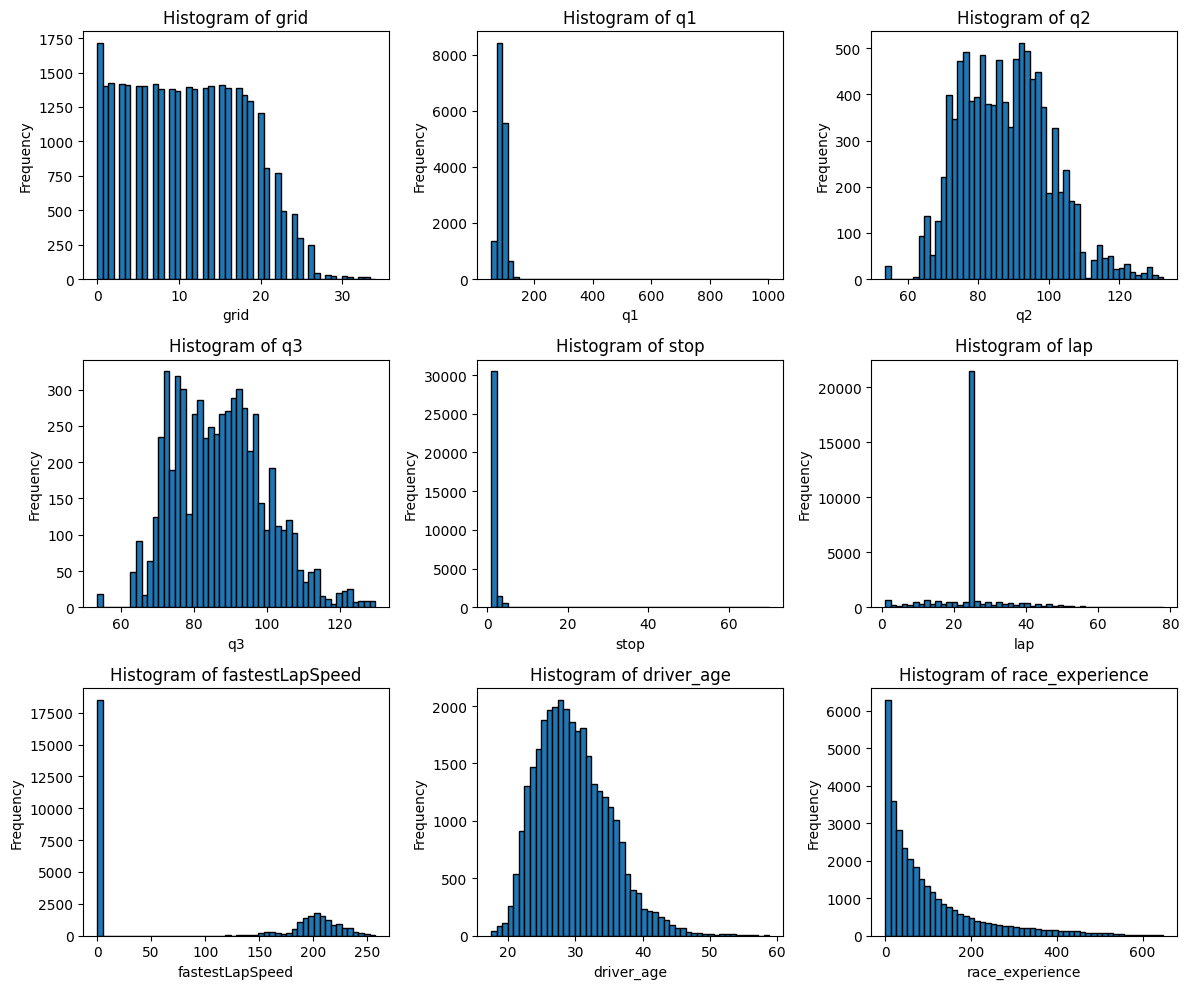

In [ ]:
numerical_columns = ['grid','q1','q2','q3','stop','lap','fastestLapSpeed','driver_age','race_experience']

# Ensure all selected columns are numeric
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

  # Create a 3x3 grid of histograms
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms
for i, column in enumerate(numerical_columns):
    axes[i].hist(df[column].dropna(), bins=50, edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


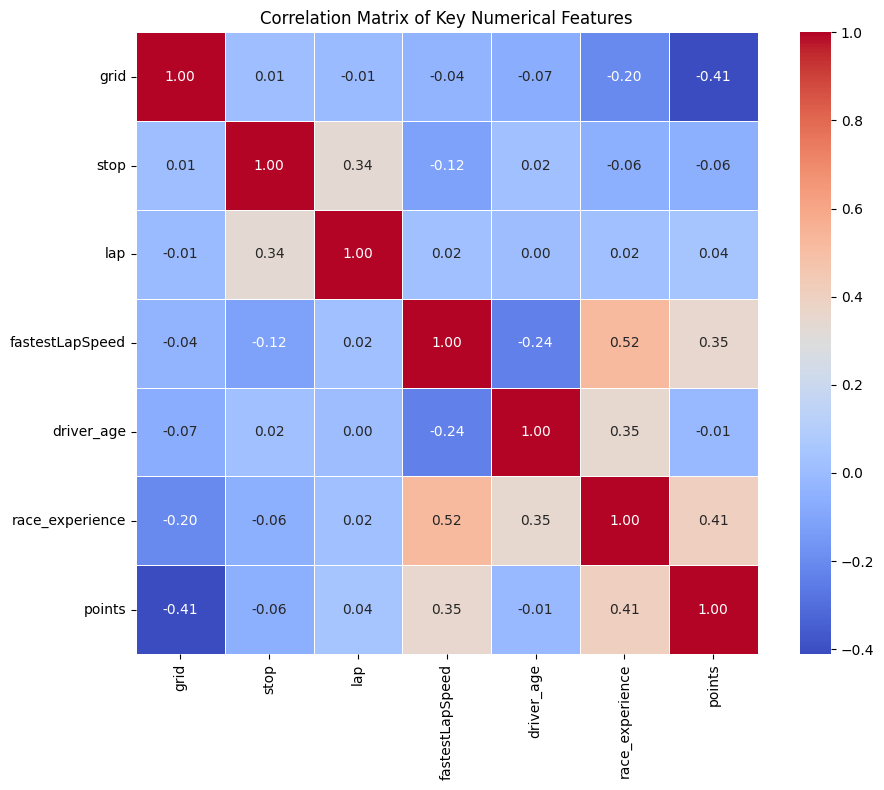

In [ ]:
corr_features = ['grid','stop','lap','fastestLapSpeed','driver_age','race_experience','points']

plt.figure(figsize=(10, 8))

corr_matrix = df[corr_features].corr()

sns.heatmap(corr_matrix,annot=True,fmt='.2f',cmap='coolwarm',square=True,linewidths=0.5)

plt.title('Correlation Matrix of Key Numerical Features')
plt.tight_layout()
plt.show()

In [ ]:
# Binary classification target: Top 10 finish
df['finished_top10'] = df['positionOrder'].apply(lambda x: 1 if x <= 10 else 0)

In [ ]:
#Removing Leakage Columns
leakage_cols = ['positionOrder','position_x','points','milliseconds_x','milliseconds_y','time_x','time_y']
df_model = df.drop(columns=leakage_cols, errors='ignore')

In [ ]:
# Selecting Categorical Columns
categorical_cols = ['nationality_x','nationality_y','country']

In [ ]:
#One-Hot Encode Categorical Variables

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df_model[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols),index=df_model.index)

In [ ]:
#Selecting Numeric Features
numeric_data = df_model.select_dtypes(include=['int64', 'float64'])

In [ ]:
#Combining Numeric + Encoded Features
all_data = pd.concat([numeric_data, encoded_df], axis=1)

In [ ]:
#Separating Features (X) and Target (y)

X = all_data.drop(columns=['finished_top10'])
y = all_data['finished_top10']

In [ ]:
#Removing ID Columns (Non-Predictive)
id_cols = ['resultId','raceId','driverId','constructorId_x','statusId']
X = X.drop(columns=id_cols, errors='ignore')

In [ ]:
#Handling Missing Values (Median Imputation)

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X),columns=X.columns, index=X.index)

In [ ]:
#Final Validation Check

print("Any missing values left?:", X.isnull().values.any())
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Any missing values left?: False
Feature matrix shape: (32555, 122)
Target vector shape: (32555,)


TRAINING AND SPLITTING

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(24416, 122) (8139, 122)
(24416,) (8139,)


In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

TESTING MODELS(LOGISTIC REGRESSION, DECISION TREE, AND RANDOM FOREST)

In [ ]:
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.8154564442806241
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4609
           1       0.78      0.80      0.79      3530

    accuracy                           0.82      8139
   macro avg       0.81      0.81      0.81      8139
weighted avg       0.82      0.82      0.82      8139



In [ ]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.8669369701437523
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4609
           1       0.85      0.84      0.85      3530

    accuracy                           0.87      8139
   macro avg       0.86      0.86      0.86      8139
weighted avg       0.87      0.87      0.87      8139



In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8959331613220297
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4609
           1       0.88      0.88      0.88      3530

    accuracy                           0.90      8139
   macro avg       0.89      0.89      0.89      8139
weighted avg       0.90      0.90      0.90      8139



TUNED RANDOM FOREST ACCURACY REPORT

In [ ]:
rf = RandomForestClassifier(random_state=42,n_jobs=-1)

param_dist = {'n_estimators': [100, 200, 300],'max_depth': [None, 10, 20, 30],'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],'max_features': ['sqrt', 'log2']}

In [ ]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy',
    random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='accuracy')

In [ ]:
print("Best Parameters:")
print(rf_random.best_params_)

Best Parameters:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30}


In [ ]:
best_rf = rf_random.best_estimator_

y_pred_best = best_rf.predict(X_test)

print("Tuned Random Forest Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report (Tuned RF):\n")
print(classification_report(y_test, y_pred_best))

Tuned Random Forest Accuracy: 0.8886841135274604
Classification Report (Tuned RF):

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4609
           1       0.87      0.88      0.87      3530

    accuracy                           0.89      8139
   macro avg       0.89      0.89      0.89      8139
weighted avg       0.89      0.89      0.89      8139



FEATURE IMPORTANCE

In [ ]:
# Extract feature importances
importances = best_rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns,'Importance': importances})

# Sort descending
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display top 15 features
feature_importance_df.head(15)

,Feature,Importance
1,laps,0.245783
0,grid,0.101838
12,position_y,0.065001
19,race_experience,0.056836
18,driver_age,0.049016
3,year,0.044857
4,round,0.027373
15,q3,0.026424
11,number,0.025974
2,fastestLapSpeed,0.025913


from matplotlib import pyplot as plt
_df_0['Importance'].plot(kind='hist', bins=20, title='Importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Importance'].plot(kind='line', figsize=(8, 4), title='Importance')
plt.gca().spines[['top', 'right']].set_visible(False)

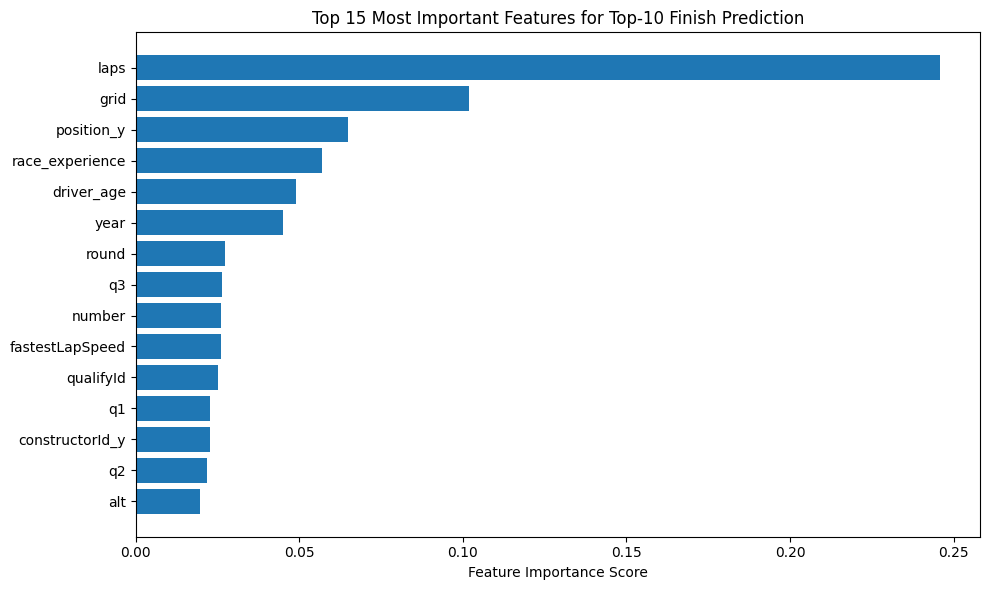

In [ ]:
plt.figure(figsize=(10, 6))

plt.barh(
    feature_importance_df['Feature'][:15][::-1],
    feature_importance_df['Importance'][:15][::-1])

plt.xlabel('Feature Importance Score')
plt.title('Top 15 Most Important Features for Top-10 Finish Prediction')
plt.tight_layout()
plt.show()

In [ ]:
feature_importance_df['Cumulative_Importance'] = (
    feature_importance_df['Importance'].cumsum())

feature_importance_df.head(10)

,Feature,Importance,Cumulative_Importance
1,laps,0.245783,0.245783
0,grid,0.101838,0.347621
12,position_y,0.065001,0.412622
19,race_experience,0.056836,0.469458
18,driver_age,0.049016,0.518474
3,year,0.044857,0.563331
4,round,0.027373,0.590704
15,q3,0.026424,0.617128
11,number,0.025974,0.643102
2,fastestLapSpeed,0.025913,0.669016


The top features collectively explain a significant portion of the model’s predictive power, indicating that a limited number of performance-related variables dominate race outcomes.

RANDOM FOREST PERFOMANCE EVALUATION (ROC-AUC CURVE)

ROC-AUC Score: 0.9594270232461798


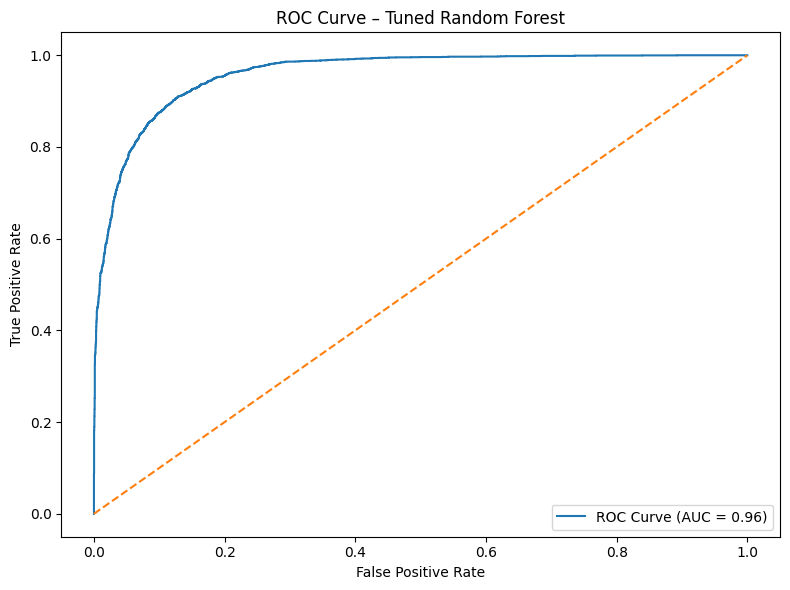

In [ ]:
# Predict probabilities
y_prob = best_rf.predict_proba(X_test)[:, 1]

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Tuned Random Forest')
plt.legend()
plt.tight_layout()
plt.show()

MODEL PERFORMACE CHARTS

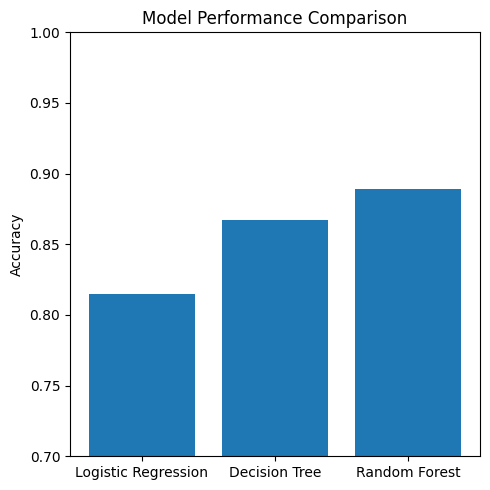

In [ ]:
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [0.815, 0.867, 0.889]

plt.figure(figsize=(5, 5))
plt.bar(model_names, accuracies)
plt.ylim(0.7, 1.0)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

PROJECT DETAILS

# Project Introduction

Predicting whether a Formula 1 driver will finish inside the top 10 is a critical task in motorsport analytics, as it helps teams optimize race strategies, improve qualifying decisions, and allocate resources efficiently. The objective of this project was to build machine learning models capable of predicting top-10 race finishes (1 = Finished in Top 10, 0 = Finished Outside Top 10) using historical Formula 1 race, qualifying, driver, constructor, and circuit data.

**Business Impact**

1. Strategic Race Planning: Teams will be able to anticipate likely top-10 outcomes and adjust tire strategy, pit stop planning, and risk tolerance during races.

2. Performance Optimization: Helps understanding key performance drivers allowing teams to prioritize qualifying performance, improving car setup decisions, and identifying races with high scoring potential.

3. Cost & Resource Efficiency: Better predictions reduce costly strategic errors and improve sponsor value through consistent results.

**Methodology**

- Dataset Preparation
- Data Sources: Multiple Formula 1 datasets (race results, qualifying data, drivers, constructors, circuits, etc.)
- Data Integration: Datasets were merged using common identifiers such as raceId, driverId, and constructorId.

**Data Cleaning**

- Removed missing and inconsistent values
- Converted time-based variables (Q1, Q2, Q3) into numerical seconds
- Removed non-predictive identifiers (URLs, names)

**Feature Engineering**

Created target variable:finished_top10

1 → Finished position ≤ 10
0 → Finished position > 10

Engineered driver age from date of birth
Selected race-relevant numerical features (grid position, qualifying times, pit stops, lap counts, speed)


**Data Splitting & Scaling**

- Train-test split: 75% training / 25% testing
Feature scaling applied where required
- One-hot encoding used for categorical variables

**Models Evaluated**

The following classification models were implemented:
Logistic Regression (Baseline model)
Decision Tree Classifier
Random Forest Classifier (Final model)

*Random Forest was further optimized using RandomizedSearchCV to improve generalization and reduce overfitting.*

**Evaluation Metrics (Classification)**

The models were evaluated using:
Accuracy: Overall correctness
Precision: Reliability of top-10 predictions
Recall: Ability to identify actual top-10 finishes
F1-score: Balance between precision and recall
ROC-AUC: Ability to distinguish between top-10 and non-top-10 finishes

# Results

**Model Performance Summary**

Logistic Regression achieved moderate accuracy and served as a baseline.
Decision Tree improved interpretability but showed signs of overfitting.
Tuned Random Forest achieved the best performance, with:

Accuracy ≈ 88.9%
Strong precision, recall, and F1-score
High ROC-AUC indicating excellent class separation


**Feature Importance Findings**

Key predictors of top-10 finishes included:
Grid position
Qualifying performance (Q1, Q2, Q3)
Fastest lap speed
Pit stop count

These results emphasize the importance of qualifying strategy and race pace over driver demographics.

**Business Insights & Recommendations**

Teams should prioritize qualifying performance, as starting position strongly influences race outcomes.
Efficient pit stop strategies improve finishing probability.
Predictive models can support race-day decision-making and long-term performance evaluation.

# Limitations & Future Scope

**Limitations**
Weather conditions and real-time race incidents were not included.
The model relies on historical performance and cannot capture sudden mechanical failures.

**Future Improvements**

- Incorporate weather and track condition data
- Use live telemetry data for real-time prediction
- Explore advanced ensemble or deep learning models

**Conclusion**

This project demonstrates the effectiveness of machine learning techniques in predicting top-10 Formula 1 race finishes using historical performance data. The Random Forest classifier emerged as the most reliable model, offering valuable insights into the factors that drive race success. These findings reinforce the potential of predictive analytics as a strategic tool in high-performance, data-driven industries such as motorsport.